In [254]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

Load ln data

In [248]:
read_file = pd.read_csv("../Raw_ln.csv")

read_file = read_file.iloc[:, :]

data = read_file.transpose()

X = data.iloc[1:, :-1]
Y = data.iloc[1:, -1]
Y = Y.astype(int)
Stages = np.zeros(13)
print(X.shape)
print(Y.shape)

(1094, 17000)
(1094,)


Load Raw data

In [255]:
read_file = pd.read_csv("../Raw_data.csv")

read_file = read_file.iloc[:, 1:]

data = read_file.transpose()

X = data.iloc[:, :-1]
Y = data.iloc[:, -1]
Y = Y.astype(int)
Stages = np.zeros(13)
print(X.shape)
print(Y.shape)

(1094, 17000)
(1094,)


perform log

In [142]:
epsi = 10e-10
X = np.log(X + epsi)
X.replace([np.inf, -np.inf], 0, inplace=True)

number of zeros:

In [256]:
print("number of zeros in data(X): ", np.where(X == 0)[0].__len__())
print("located at: ", np.where(X == 0))

number of zeros in data(X):  279762
located at:  (array([   0,    0,    0, ..., 1093, 1093, 1093], dtype=int64), array([   10,   128,   175, ..., 16595, 16874, 16964], dtype=int64))


replace machine read error(replace 0 with mean):

In [257]:
means = (np.mean(X, axis=0) * X.shape[0]) / (X.shape[0] - np.count_nonzero(X == 0, axis=0))
zero_indices = np.where(X == 0)
X.values[zero_indices] = means[zero_indices[1]]

In [259]:
np.transpose(X).to_csv("../Raw_avg_fix.csv")

In [ ]:
print(np.histogram(X.iloc[:, 1500], bins=100)) # edit this to view a histogram

'clip' the edges to cancle the effect of rare samples:

clip by 1% value:

In [37]:
thresholds = np.percentile(X, 1, axis=0) # (TODO) - test precentile output

clip by 1% order:

In [263]:
# (TODO) - test median output
smallest_indices = np.argsort(X, axis=0)[int(X.shape[0] * 0.01) - 1]

thresholds = X.values[smallest_indices, np.arange(X.shape[1])]

Debug snippet:

In [267]:
print(thresholds)
below_threshold_indices = np.where(X <= thresholds)
print(below_threshold_indices[0].__len__())


[ 7.8478  0.3758 11.0488 ...  9.3899  0.5366  9.0384]
170060


clip action:

In [268]:
below_threshold_indices = np.where(X < thresholds)
print(below_threshold_indices[0].__len__())
X.values[below_threshold_indices] = thresholds[below_threshold_indices[1]]

152946


stage frequency analysis:

In [131]:
for i in range(Y.size):
    Stages[Y.iloc[i]] += 1
print(Stages)

[  7.  90.  86.   6.   6. 358. 257.   2. 156.  27.  65.  20.  14.]


Stage union:

In [269]:
for i in range(Y.size):
    if (Y[i] <= 3): # stages 0, I, IA, IB
        Y[i] = 0
    elif (Y[i] <= 6): # stages II, IIA, IIB
        Y[i] = 1
    elif (Y[i] <= 10): # stages III, IIIA, IIIB, IIIC
        Y[i] = 2
    else: # stages IV, X
        Y[i] = 3 
Stages = np.zeros(4)
for i in range(Y.size):
    Stages[Y.iloc[i]] += 1
print(Stages)

[189. 621. 250.  34.]


Stage deletion:

In [78]:
SumStages = 0
bar = 90
Stage_counter = 13
for i in range(Stages.size):
    if (Stages[i] < bar):
        X = X.drop(index=X.iloc[int(SumStages):int(SumStages) + int(Stages[i]), :].index.tolist(), inplace=False)
        Y = Y.drop(index=Y.iloc[int(SumStages):int(SumStages) + int(Stages[i])].index.tolist(), inplace=False)
        Stage_counter = Stage_counter - 1
    else:
        SumStages += Stages[i]

Stages = np.zeros(Stage_counter)
for i in range(Y.size):
    Stages[Y.iloc[i]] += 1
print(Stages)

run TSNE:

In [25]:
X = TSNE(n_components=2, learning_rate='auto', perplexity=3).fit_transform(X)
df = pd.DataFrame()
df["y"] = Y
df["Gene Group 1"] = X[:,0]
df["Gene Group 2"] = X[:,1]

sns.scatterplot(x="Gene Group 1", y="Gene Group 2", hue=df.y.tolist(),palette=sns.color_palette("hls", 4),data=df).set(title="TSNE distribution")

gene STD clean:

In [8]:
bar = 0.05
print("total genes: ", X.shape[1])
X = X.loc[:,X.std(axis=0) > bar]
print("reduced to ", X.shape[1], "genes with STD > ", bar)

total genes:  17001
reduced to  15116 genes with STD >  0.05


SVD clean:

In [162]:
svd = TruncatedSVD(n_components=1094, random_state=42)
X1 = svd.fit_transform(X)
Sigma = np.diag(svd.singular_values_)
V = svd.components_
print(svd.singular_values_)
# print(np.mean(np.abs(X - X1)))
X = X1

[3.56685762e+04 1.18656013e+03 1.12792558e+03 ... 1.74428916e+01
 1.73866101e+01 1.68132219e+01]


In [134]:
bar = 30
per = 0.5
found = [False, False]
for i in range(svd.singular_values_.size):
    if svd.singular_values_[i] < bar and not found[0]:
        print("trauncate at ", i, "for values > ", bar)
        found[0] = True
    elif i/svd.singular_values_.size > per and not found[1]:
        print(per * 100, "% value: ", svd.singular_values_[i-1])
        found[1] = True
    if found[0] and found[1]:
        break
if not found[0]:
    print("all value's are greater then ", bar)

50.0 % value:  68.80081988823748
trauncate at  990 for values >  30


Shuffle data:

In [ ]:
X, Y = shuffle(X, Y, random_state=0)

split to train and test groups:

In [270]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

normal distribution:

In [152]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

range distribution:

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

logistical regression:

In [278]:
model = LogisticRegression(random_state=0, max_iter=1000, multi_class="multinomial", n_jobs=-1, C=0.0002, class_weight='balanced')

Logistic Regression Cross Validation

In [245]:
model = LogisticRegressionCV(cv=3,Cs=1, random_state=0, max_iter=100, multi_class="multinomial",class_weight='balanced', n_jobs=-1)

In [ ]:
# (TODO) - add more models(adaboost)

Linear regression:

In [17]:
model = LinearRegression(copy_X=True, n_jobs=-1)

train the model and predict:

In [272]:
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

report for classification:

In [273]:
print("test score: ")
print(metrics.classification_report(y_true=Y_test, y_pred=Y_test_pred))
print("train score: ")
print(metrics.classification_report(y_true=Y_train, y_pred=Y_train_pred))

test score: 
              precision    recall  f1-score   support

           0       0.27      0.37      0.31        38
           1       0.67      0.55      0.60       134
           2       0.44      0.55      0.49        44
           3       0.00      0.00      0.00         3

    accuracy                           0.51       219
   macro avg       0.35      0.37      0.35       219
weighted avg       0.54      0.51      0.52       219

train score: 
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       151
           1       1.00      0.90      0.95       487
           2       0.89      0.99      0.94       206
           3       1.00      1.00      1.00        31

    accuracy                           0.94       875
   macro avg       0.94      0.97      0.95       875
weighted avg       0.95      0.94      0.94       875



classify for linear regression and report:

In [144]:
for i in range(Y_test_pred.shape[0]):
    if Y_test_pred[i] % 1 < 0.5:
        Y_test_pred[i] = int(Y_test_pred[i])
    else:
        Y_test_pred[i] = int(Y_test_pred[i] + 1)

for i in range(Y_train_pred.shape[0]):
    if Y_train_pred[i] % 1 < 0.5:
        Y_train_pred[i] = int(Y_train_pred[i])
    else:
        Y_train_pred[i] = int(Y_train_pred[i] + 1)

print(metrics.classification_report(y_true=Y_test, y_pred=Y_test_pred))
print(metrics.classification_report(y_true=Y_train, y_pred=Y_train_pred))

              precision    recall  f1-score   support

           0       0.27      0.42      0.33        38
           1       0.69      0.52      0.59       134
           2       0.36      0.43      0.39        44
           3       0.00      0.00      0.00         3

    accuracy                           0.48       219
   macro avg       0.33      0.34      0.33       219
weighted avg       0.54      0.48      0.50       219

              precision    recall  f1-score   support

           0       0.61      0.98      0.75       151
           1       0.97      0.69      0.81       487
           2       0.73      0.89      0.80       206
           3       0.97      1.00      0.98        31

    accuracy                           0.80       875
   macro avg       0.82      0.89      0.84       875
weighted avg       0.85      0.80      0.80       875



test group Confusion matrix:

<Axes: >

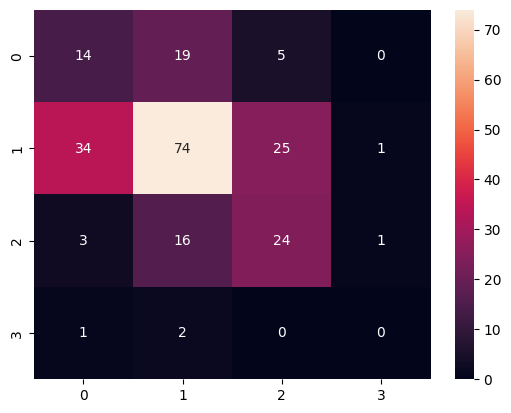

In [274]:
conMat = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(conMat, annot=True, fmt='g') 

train group confusion matrix

<Axes: >

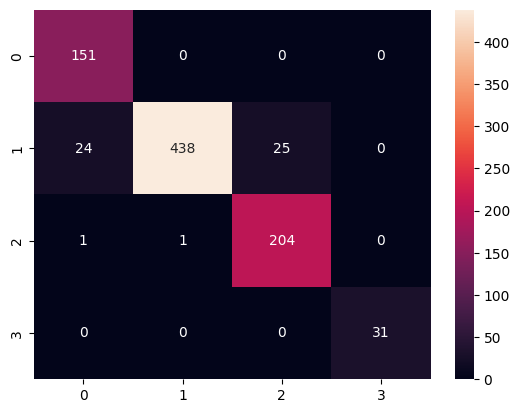

In [275]:
conMat = confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(conMat, annot=True, fmt='g')

manual printing function to print a dict report:

In [276]:
def print_report_dict(report):
    print("\t      precision    recall  f1-score   support\n")
    for i in range(Stages.shape[0]):
        indexStr = " " * (4 - str(i).__len__()) + "%d" % (i)
        supportStr = " " * (7 - str(int(report[str(i)]['support'])).__len__()) + "%d" % (report[str(i)]['support'])
        print("\t%s       %.2f      %.2f      %.2f   %s" % (indexStr, report[str(i)]['precision'], report[str(i)]['recall'], report[str(i)]['f1-score'], supportStr))
    print()
    supportStr = " " * (7 - str(int(report['macro avg']['support'])).__len__()) + "%d" % (report['macro avg']['support'])
    print("    accuracy                           %.2f   %s" % (report['accuracy'], supportStr))
    print("   macro avg       %.2f      %.2f      %.2f   %s" % (report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'], supportStr))
    print("weigthed avg       %.2f      %.2f      %.2f   %s\n" % (report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'], supportStr))


stability check:

In [277]:
n = 5
test_reports = np.zeros((n), dtype=object)
train_reports = np.zeros((n), dtype=object)

test_avg_report = {'accuracy': 0,
        'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 
        'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
train_avg_report = {'accuracy': 0,
        'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 
        'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
test_std_report = {'accuracy': 0,
        'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 
        'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
train_std_report = {'accuracy': 0,
        'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 
        'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
for i in range(Stages.shape[0]):
    test_avg_report.update({str(i): {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}})
    test_std_report.update({str(i): {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}})
    train_avg_report.update({str(i): {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}})
    train_std_report.update({str(i): {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}})

for i in range(n):
    # rand = random.randint(0, 100)
    
    # shuffle and split
    X, Y = shuffle(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    
    # scale:
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # fit and predict
    model.fit(X_train, Y_train)
    Y_test_pred = model.predict(X_test)
    Y_train_pred = model.predict(X_train)
    
    # score
    test_reports[i] = metrics.classification_report(y_true=Y_test, y_pred=Y_test_pred, output_dict=True)
    train_reports[i] = metrics.classification_report(y_true=Y_train, y_pred=Y_train_pred, output_dict=True)
    
    # calc avg
    for label, dictData in test_reports[i].items():
        if label != 'accuracy':
            for k in set(dictData):
                test_avg_report[label][k] += dictData.get(k, 0) / n
        else:
            test_avg_report[label] += dictData / n
    for label, dictData in train_reports[i].items():
        if label != 'accuracy':
            for k in set(dictData):
                train_avg_report[label][k] += dictData.get(k, 0) / n
        else:
            train_avg_report[label] += dictData / n
  
# calc std
for i in range(n):    
    for label, dictData in test_reports[i].items():
        if label != 'accuracy':
            for k in set(dictData):
                test_std_report[label][k] += ((dictData.get(k, 0) - test_avg_report[label][k]) ** 2) / n
        else:
            test_std_report[label] += ((dictData - test_avg_report['accuracy']) ** 2) / n
    for label, dictData in train_reports[i].items():
        if label != 'accuracy':
            for k in set(dictData):
                train_std_report[label][k] += ((dictData.get(k, 0) - train_avg_report[label][k]) ** 2) / n
        else:
            train_std_report[label] += ((dictData - train_avg_report['accuracy']) ** 2) / n
            

print("test average report: ")
print_report_dict(test_avg_report)
print("test std: ")
print_report_dict(test_std_report)

print("train average report: ")
print_report_dict(train_avg_report)
print("train std: ")
print_report_dict(test_std_report)

test average report: 
	      precision    recall  f1-score   support

	   0       0.31      0.38      0.34        37
	   1       0.63      0.59      0.61       124
	   2       0.38      0.42      0.40        47
	   3       0.10      0.02      0.03         9

    accuracy                           0.49       219
   macro avg       0.36      0.35      0.35       219
weigthed avg       0.50      0.49      0.49       219

test std: 
	      precision    recall  f1-score   support

	   0       0.00      0.00      0.00        15
	   1       0.00      0.01      0.00        41
	   2       0.00      0.00      0.00        30
	   3       0.04      0.00      0.00         1

    accuracy                           0.00         0
   macro avg       0.00      0.00      0.00         0
weigthed avg       0.00      0.00      0.00         0

train average report: 
	      precision    recall  f1-score   support

	   0       0.85      1.00      0.92       151
	   1       1.00      0.91      0.95       496
	 